# Monet using GAN

In [31]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# import tensorflow_addons as tfa
# from kaggle_datasets import KaggleDatasets

if os.path.exists(r'C:\Users\kuusnin\tempwork\temp\gan-getting-started'):
    datapath = r'C:\Users\kuusnin\tempwork\temp\gan-getting-started'
else:
    datapath = r'C:\Users\nikok\Documents\Monet using GAN'



## Brief description of the problem and data (5 pts)

*Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data.*

In [32]:
monet_files = os.listdir(os.path.join(datapath, 'monet_tfrec'))
photo_files = os.listdir(os.path.join(datapath, 'photo_tfrec'))
monet_filenames = [os.path.join(datapath, 'monet_tfrec', f) for f in monet_files]
photo_filenames = [os.path.join(datapath, 'photo_tfrec', f) for f in photo_files]
print(20*'*', 'Monet paintings', 20*'*')
print('First filename:', monet_files[0], '\nNumber of files:', len(monet_files))
print(20*'*', 'Photos', 20*'*')
print('First filename:', photo_files[0], '\nNumber of files:', len(photo_files))

******************** Monet paintings ********************
First filename: monet00-60.tfrec 
Number of files: 5
******************** Photos ********************
First filename: photo00-352.tfrec 
Number of files: 20


### Figure out the contents of the tfrec files

From the code below we can see that each record/example contains three fields: 
* target: label of the image. Not needed in this work 
* image_name: name of the image
* image: the actual image data

Both of the data sets appear to have the same structure. 

In [33]:
# The following code is adapted from an answer from Microsoft Copilot
import tensorflow as tf
from google.protobuf.json_format import MessageToJson
import json

def iterate_record(dataset):
    # Initialize a counter
    record_count = 0
    # Iterate through the dataset and count the records
    for _ in dataset:
        record_count += 1
    print(f'Total number of records: {record_count}')
    
    # Iterate through the dataset and parse each record
    for raw_record in dataset.take(1):  # Adjust the number to read more records
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        json_message = MessageToJson(example)
        parsed_record = json.loads(json_message)
        print(json.dumps(parsed_record, indent=2))

# Create a TFRecordDataset
print(20*'*', 'Monet paintings', 20*'*')
raw_monet_dataset = tf.data.TFRecordDataset(monet_filenames)
iterate_record(raw_monet_dataset)

print(20*'*', 'Photos', 20*'*')
raw_photo_dataset = tf.data.TFRecordDataset(photo_filenames)
iterate_record(raw_photo_dataset)


******************** Monet paintings ********************
Total number of records: 300
{
  "features": {
    "feature": {
      "target": {
        "bytesList": {
          "value": [
            "bW9uZXQ="
          ]
        }
      },
      "image_name": {
        "bytesList": {
          "value": [
            "MjVjOTkwNDc4Mg=="
          ]
        }
      },
      "image": {
        "bytesList": {
          "value": [
            "/9j/4AAQSkZJRgABAQEBLAEsAAD/2wBDAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgr/2wBDAQICAgICAgUDAwUKBwYHCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgr/wAARCAEAAQADAREAAhEBAxEB/8QAHgAAAgIDAQEBAQAAAAAAAAAABgcEBQMICQIACgH/xABLEAACAQIEAwUFBAkDAQcBCQADBAUGEwACByMUM0MIEhVTYwEiJHODFjI0kwkXJUSjs8PT8BFC4/MhJjVFUlRkGAoxUVVicnS01P/EABsBAAIDAQEBAAAAAAAAAAAAAAQFAgMGAAcB/8QAPhEAAQMCBQIEAwYEBQQDAQAAAwAEEwIFEhQiIzMGQxUkMlNCY3MBg5Ojs/AHUsPTFiU0YuMRRHLzFyExNf/aAAwDAQACEQMRAD8As9GIGH0+p+nqbpKBAThxXxLMiJbGS3c6ePFw

We can parse the data now since the structure of the tfrecord is known.

In [34]:
def parse_tfrecord_fn(example):
    feature_description = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_jpeg(example["image"], channels=3)
    return example

monet_dataset = raw_monet_dataset.map(parse_tfrecord_fn)
photo_dataset = raw_photo_dataset.map(parse_tfrecord_fn)



## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

*Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis?*

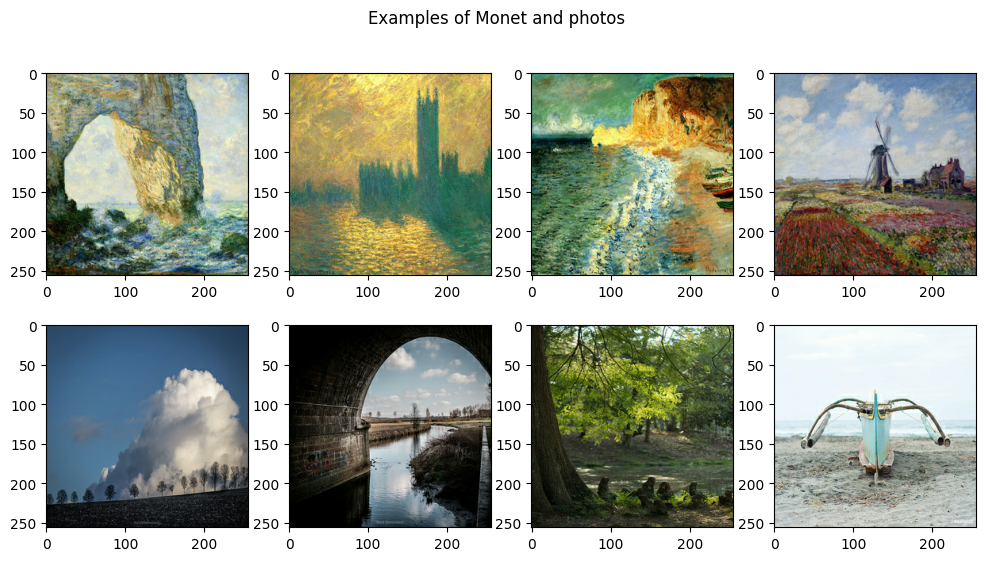

In [35]:
fig = plt.figure(figsize=(12, 6))
i = 0
for data in monet_dataset.take(4):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(data['image'].numpy())
    i += 1
for data in photo_dataset.take(4):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(data['image'].numpy())
    i += 1
fig.suptitle('Examples of Monet and photos')
plt.show()

In [100]:
dims = []
for data in photo_dataset:
    img = data['image'].numpy().shape
    dims.append(img)
print('Unique shapes of the photos data:', set(dims))

dims = []
for data in monet_dataset:
    dims.append(data['image'].numpy().shape)
print('Unique shapes of the Monet data:', set(dims))

Unique shapes of the photos data: {(256, 256, 3)}
Unique shapes of the Monet data: {(256, 256, 3)}


In [109]:
def plot_histogram(dataset, title):
    rgb = []
    for data in dataset:
        rgb.append(data['image'].numpy())
    rgb = np.array(rgb)
    # rgb.shape
    pic_channels = ['red', 'green', 'blue']
    rgb_df = pd.DataFrame()
    for i, clr in enumerate(pic_channels):
        df = pd.DataFrame(rgb[:,:,:,i].ravel(), columns=['val'])
        df['color'] = clr
        rgb_df = pd.concat([rgb_df, df])
    print('Minimum and maximmum values in ' + title + ' data: ', min(rgb_df.val), '&', max(rgb_df.val))
    sns.histplot(rgb_df.sample(1000), x='val', hue='color', bins=30, multiple='dodge', color=['green', 'blue', 'red'])
    plt.grid()
    plt.title('Histogram of ' + title)
    plt.show()



Minimum and maximmum values in sample photos data:  0 & 255


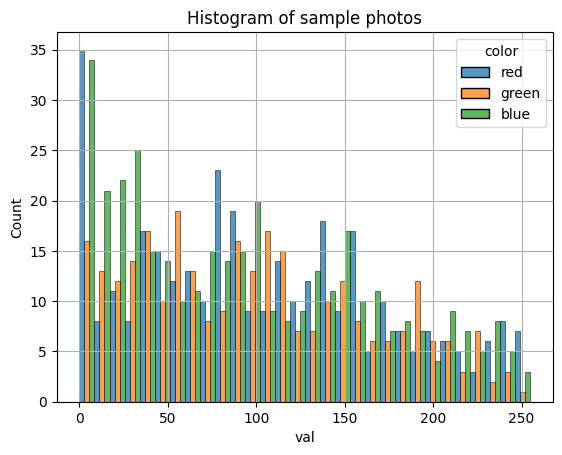

Minimum and maximmum values in Monet paintings data:  0 & 255


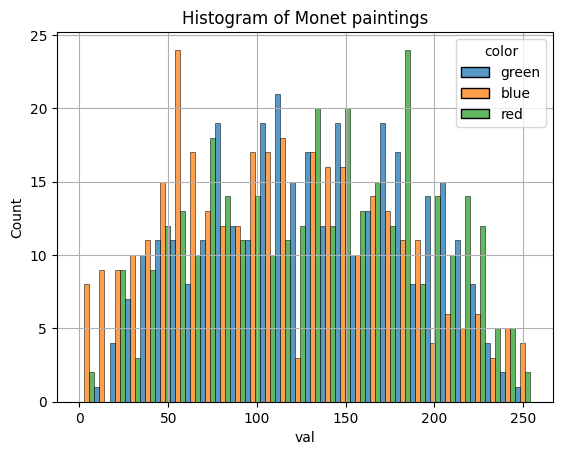

In [ ]:
plot_histogram(photo_dataset.take(300), title='sample photos')
plot_histogram(monet_dataset, title='Monet paintings')


## Model Architecture (25 pts)

*Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem.*

*Since we did not learn NLP-specific techniques such as word embeddings in the lectures, we recommend looking at Kaggle tutorials, discussion boards, and code examples posted for this challenge.  You can use any resources needed, but make sure you “demonstrate” you understood by including explanations in your own words. Also importantly, please have a reference list at the end of the report.*

*There are many methods to process texts to matrix form (word embedding), including TF-IDF, GloVe, Word2Vec, etc. Pick a strategy and process the raw texts to word embedding. Briefly explain the method(s) and how they work in your own words.*

*Build and train your sequential neural network model (You may use any RNN family neural network, including advanced architectures LSTM, GRU, bidirectional RNN, etc.).*

## Results and Analysis (35 pts)

*Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.*

*Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.*

## Conclusion (15 pts)

*Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?*

# Sources

https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial
